<a href="https://colab.research.google.com/github/kollerbud/Time_series/blob/master/Time_series_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
16796/16796 [==============================] - 12s 686us/step - loss: 0.0151
Epoch 2/10
16796/16796 [==============================] - 8s 464us/step - loss: 0.0087
Epoch 3/10
16796/16796 [==============================] - 8s 460us/step - loss: 0.0079
Epoch 4/10
16796/16796 [==============================] - 8s 456us/step - loss: 0.0073
Epoch 5/10
16796/16796 [==============================] - 8s 449us/step - loss: 0.0060
Epoch 6/10
16796/16796 [==============================] - 8s 459us/step - loss: 0.0050
Epoch 7/10
16796/16796 [==============================] - 8s 457us/step - loss: 0.0047
Epoch 8/10
16796/16796 [==============================] - 8s 459us/step - loss: 0.0046
Epoch 9/10
16796/16796 [==============================] - 8s 448us/s

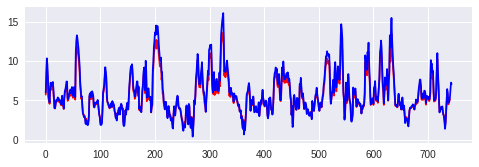

the root of mean squared error is 0.5118925505838048


In [1]:
'''
Authors:Astha Bhawsinka, Daemon Li, Kevin Li, Panyakorn Rakpanitmanee
IOE 565 Time Series Wind speed generation forecast

Based on ideas of Jason Brownlee and sources found on Kaggle.com:
https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
'''

import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Load data
link = 'https://raw.githubusercontent.com/kollerbud/Time_series/master/wind_data.csv'
df =pd.read_csv(link, sep=',', index_col='date', parse_dates=['date'])
cut_off_date = '2008-12-01'
train_set =df[df.index < cut_off_date]
test_set =df[df.index > cut_off_date]

train_station1 =train_set['ws_4'].values.reshape(-1,1)
test_station1 =test_set['ws_4'].values.reshape(-1,1)

#scale data to feed into model
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler(feature_range=(0,1))
train_station1_scaled =scaler.fit_transform(train_station1)
test_station1_scaled =scaler.fit_transform(test_station1)

###################################
timesteps=3 
##################################

x_train=[]
y_train=[]
for i in range(timesteps, len(train_station1_scaled)):
    x_train.append(train_station1_scaled[i-timesteps:i,0])
    y_train.append(train_station1_scaled[i,0])
    
x_train, y_train =np.array(x_train), np.array(y_train)
x_train =np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Seed the model
np.random.seed(12)

# building LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# tuning paramter
unit, verbose, epochs, batch_size =5, True, 10, 24
n_outputs =1
#initialize
reg =Sequential()
# 1st layer
reg.add(LSTM(units=unit, return_sequences=True, input_shape=(timesteps,1)))
reg.add(Dropout(0.2))
# 2nd layer
reg.add(LSTM(units=unit, return_sequences=True))
reg.add(Dropout(0.2))
# 3rd layer
reg.add(LSTM(units=unit, return_sequences=True))
reg.add(Dropout(0.2))
# 4th layer
reg.add(LSTM(units=unit))
reg.add(Dropout(0.2))
#output layer
reg.add(Dense(units=n_outputs))

#compile
reg.compile(optimizer='rmsprop', loss='mse')
reg.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

total =pd.concat((train_set['ws_4'], test_set['ws_4']), axis=0)
inputs =total[len(df)-len(test_station1)-timesteps:].values
inputs =inputs.reshape(-1,1)
inputs =scaler.transform(inputs)

x_test =[]
for i in range(timesteps, len(test_station1)):
    x_test.append(inputs[i-timesteps:i,0])
x_test =np.array(x_test)
x_test =np.reshape(x_test,(x_test.shape[0], timesteps,1))
predicted =reg.predict(x_test)
predition =scaler.inverse_transform(predicted)

plt.subplot(2,1,1)
plt.plot(predition, color='red')
plt.plot(test_station1, color='blue')
plt.show()
test_s1_rmse =test_station1[:-timesteps,:]

def return_rmse(test, predicted):
    rmse =math.sqrt(mean_squared_error(test, predicted))
    print('the root of mean squared error is {}'.format(rmse))
return_rmse(predition, test_s1_rmse)